# Instalações

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch
!pip install ultralytics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

# Destilação


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from ultralytics import YOLO  # Biblioteca YOLOv8

# Função de perda de distilação (KL Divergence)
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, temperature=2.0):
        super(DistillationLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        ce_loss = self.ce_loss(student_logits, labels)
        distill_loss = self.kl_div(
            torch.log_softmax(student_logits / self.temperature, dim=1),
            torch.softmax(teacher_logits / self.temperature, dim=1)
        ) * (self.temperature ** 2)
        return self.alpha * ce_loss + (1 - self.alpha) * distill_loss

# Definir device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregar modelo professor
teacher_model = YOLO('yolov8m-cls.pt').model.to(device)

# Carregar modelo aluno
student_model = YOLO('yolov8n-cls.pt').model.to(device)

# Imprimir a estrutura do modelo aluno para identificar a última camada
print(student_model)

# Ajustar a última camada para o número de classes do dataset
num_classes = 15  # Número de classes do seu dataset (neste caso, 15)
# Procure a camada correta para ajustar
# Vamos tentar ajustar a camada final após identificar a estrutura correta
if hasattr(student_model.model, 'classifier'):
    in_features = student_model.model.classifier[-1].in_features
    student_model.model.classifier[-1] = nn.Linear(in_features, num_classes).to(device)
else:
    # Caso não haja 'classifier', procure por outra camada final comum
    for name, module in student_model.named_modules():
        if isinstance(module, nn.Linear):
            in_features = module.in_features
            setattr(student_model, name, nn.Linear(in_features, num_classes).to(device))
            break
    else:
        raise AttributeError("O modelo aluno não possui uma camada 'classifier' ou 'nn.Linear' esperada.")

# Certificar que os parâmetros do modelo aluno requerem gradientes
for param in student_model.parameters():
    param.requires_grad = True

# Configurar otimizador
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
loss_fn = DistillationLoss(alpha=0.5, temperature=2.0)

# Definir transformações para pré-processamento dos dados
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregar conjunto de dados de treinamento
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data/dataset/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)

num_epochs = 100
# Loop de treinamento
for epoch in range(num_epochs):
    student_model.train()  # Colocar o modelo aluno em modo de treinamento
    for inputs, labels in train_loader:
        # Mover inputs e labels para o dispositivo (GPU ou CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Obter logits do modelo professor
        with torch.no_grad():
            teacher_outputs = teacher_model(inputs)
            if isinstance(teacher_outputs, (list, tuple)):
                teacher_logits = teacher_outputs[0]  # Ajuste conforme necessário
            else:
                teacher_logits = teacher_outputs

        # Obter logits do modelo aluno
        student_outputs = student_model(inputs)
        if isinstance(student_outputs, (list, tuple)):
            student_logits = student_outputs[0]  # Ajuste conforme necessário
        else:
            student_logits = student_outputs

        # Calcular a perda
        loss = loss_fn(student_logits, teacher_logits, labels)

        # Backpropagation e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Salvar o modelo aluno usando a função de salvamento do YOLO
#student_model.save('/content/drive/MyDrive/detector/student_model_destilado(teste2).pt')


100%|██████████| 32.7M/32.7M [00:00<00:00, 296MB/s]


100%|██████████| 5.30M/5.30M [00:00<00:00, 105MB/s]


ClassificationModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/100, Loss: 1.4305224418640137
Epoch 2/100, Loss: 1.1829873323440552
Epoch 3/100, Loss: 0.7842845916748047
Epoch 4/100, Loss: 0.7712419629096985
Epoch 5/100, Loss: 0.5557947754859924
Epoch 6/100, Loss: 0.5769033432006836
Epoch 7/100, Loss: 0.45357197523117065
Epoch 8/100, Loss: 0.43317556381225586
Epoch 9/100, Loss: 0.46431392431259155
Epoch 10/100, Loss: 0.39227545261383057
Epoch 11/100, Loss: 0.37027835845947266
Epoch 12/100, Loss: 0.38382259011268616
Epoch 13/100, Loss: 0.37950605154037476
Epoch 14/100, Loss: 0.35333696007728577
Epoch 15/100, Loss: 0.3452127277851105
Epoch 16/100, Loss: 0.353685200214386
Epoch 17/100, Loss: 0.3408954441547394
Epoch 18/100, Loss: 0.30679717659950256
Epoch 19/100, Loss: 0.3051609992980957
Epoch 20/100, Loss: 0.30308395624160767
Epoch 21/100, Loss: 0.27088111639022827
Epoch 22/100, Loss: 0.3091912269592285
Epoch 23/100, Loss: 0.30812180042266846
Epoch 24/100, Loss: 0.2738242447376251
Epoch 25/100, Loss: 0.28084123134613037
Epoch 26/100, Loss: 0.

In [ ]:
yolo_student = YOLO('yolov8n-cls.pt')  # Inicializar um novo objeto YOLO
yolo_student.model = student_model  # Atribuir o modelo treinado ao objeto YOLO
yolo_student.save('/content/drive/MyDrive/detector/classify_m-cls_to_n-cls_BALLS_teste4.pt')

In [ ]:
# Carregar o modelo aluno salvo
student_model = YOLO('/content/drive/MyDrive/detector/classify_m-cls_to_n-cls_BALLS_teste4.pt').model
student_model.to(device)
student_model.eval()  # Colocar o modelo em modo de avaliação, se necessário

ClassificationModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
   

In [ ]:
!yolo task=classify mode=predict model='/content/drive/MyDrive/detector/classify_m-cls_to_n-cls_BALLS_teste4.pt' source='/content/drive/MyDrive/teste/download.jpg' save=True save_txt=True save_conf=True

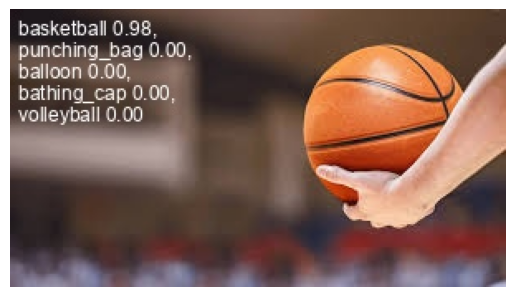

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = '/content/runs/classify/predict/download.jpg'

image = mpimg.imread(img)
plt.imshow(image)
plt.axis('off')
plt.show()